In [1]:
using CSV, DataFrames
using PyCall
using CairoMakie

include("./src/cubes.jl")
include("./src/network.jl")

@pyimport powerlaw as powlaw
so = pyimport("scipy.optimize")
st = pyimport("scipy.stats")

PyObject <module 'scipy.stats' from 'C:\\Users\\gabipana\\.julia\\conda\\3\\lib\\site-packages\\scipy\\stats\\__init__.py'>

In [2]:
region = "california"

# Select 3 of the best cell sizes from parameter dependency analysis
if region == "romania"
    cell_sizes = [3.5,  4.5,  5.5];
    multiplier = [0.6, 1.0, 1.5]
elseif region == "california"
    cell_sizes = [1.0, 1.5, 2.0];
    multiplier = [0.8, 1.0, 2.2]
elseif region == "italy"
    cell_sizes = [4.0, 4.5, 5.0];
    multiplier = [0.4, 1.0, 2.5]
elseif region == "japan"
    cell_sizes = [2.5, 3.0, 3.5];
    multiplier = [0.3, 1.0, 3.0]
end;
# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);
# magnitude_threshold = 0.0

# Make path for results
mkpath("./results/$region")

i=1

1

In [3]:
df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
MG = create_network(df, df_cubes)
degrees=Float64[]
for i in 1:nv(MG)
    push!(degrees, get_prop(MG, i, :degree))
end
# x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)


In [4]:
function ccdf_degrees(data)
    sorted_data = sort(data)
    n = length(sorted_data)
    
    cumulative = range(1, n) / n
    complementary_cumulative = 1 .- collect(cumulative)
    pushfirst!(complementary_cumulative, 1)

    ccdf_indices = unique(i -> sorted_data[i], 1:length(sorted_data))
    ccdf = [complementary_cumulative[i] for i in ccdf_indices]

    sorted_data_unique = unique(sorted_data)

    return(sorted_data_unique, ccdf)
end
    

ccdf_degrees (generic function with 1 method)

In [7]:
x, y = ccdf_degrees(degrees)

([1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0  …  954.0, 956.0, 970.0, 1010.0, 1084.0, 1264.0, 1342.0, 1456.0, 2032.0, 2600.0], [1.0, 0.9999953783085533, 0.42467798364845566, 0.2720004067088473, 0.1998465598439717, 0.15673542202975443, 0.1281964773467794, 0.10699677868106172, 0.09157881601508522, 0.07978888113471772  …  4.621691446637932e-5, 4.1595223019719185e-5, 3.697353157305905e-5, 3.235184012639891e-5, 2.7730148679849798e-5, 2.310845723318966e-5, 1.8486765786529524e-5, 1.3865074339869388e-5, 9.243382893320273e-6, 4.621691446660137e-6])

In [8]:
fit_lomax = pyeval("""lambda fit: lambda a, b: fit(a, b)""")
@. lomax_ccdf(x, k) = k*(1+x)^(-k-1)
popt_lomax, pcov_lomax = so.curve_fit(fit_lomax((x, k)->lomax_ccdf(x, k)), x, y, p0=[1.5], bounds=(0, Inf), maxfev=5000)

k = round(popt_lomax[1], digits=2)
println("\n\nk= ", k)



k= 1.1


In [51]:
(s, loc, scale) = st.lognorm.fit(x)

(4.820466154795028, 0.9999999995901714, 5.0617281434516475)

In [50]:
st.lognorm.cdf(x, s, loc, scale)

258-element Vector{Float64}:
 0.003246622971776526
 0.25685395028713576
 0.9997375823650009
 0.9999999999999809
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [48]:
lognorm_ccdf = 1 .- st.lognorm.cdf(x, s, loc, scale)

258-element Vector{Float64}:
 0.9999992839557597
 0.6317234415698355
 0.5432066376161613
 0.501015468922045
 0.4731892063768761
 0.4524830957722854
 0.43603916266667575
 0.4224325455748196
 0.41084945250296534
 0.40078128514132205
 ⋮
 0.1385112229638592
 0.13784521601089605
 0.1360055581244226
 0.1328273337708894
 0.12610013509875284
 0.12354366909489167
 0.12012166788537781
 0.10682937042910612
 0.09770769812768287

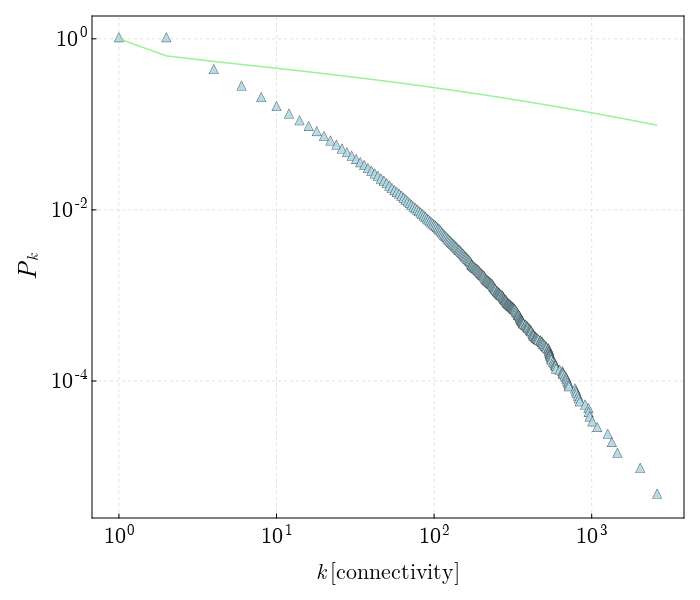

In [41]:
markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", ylabelsize = 26, xscale=log10, yscale=log10,
xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)


scatter!(ax1, x, y,
    color=(colors[1], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

ln = lines!( x, lognorm_ccdf,
color=(colors[2], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

fig

In [13]:
(c, loc, scale) = st.lomax.fit(degrees)

(1.595440148021508, 0.9999999999404472, 4.145918957524071)

In [14]:
c

1.595440148021508

In [17]:
lomax_cccdf = 1 .- st.lomax.cdf(x, c)

258-element Vector{Float64}:
 0.3309212523052105
 0.17329322926828528
 0.07670703443074778
 0.0448432063778853
 0.030030543310230473
 0.021803203095950185
 0.01670206052339751
 0.013292809704097852
 0.01088660312236256
 0.00911643764083181
 ⋮
 1.7544193827156995e-5
 1.7142355987820324e-5
 1.6073089816659447e-5
 1.4359969887522972e-5
 1.1240877960339013e-5
 1.0217436406279035e-5
 8.972007427887618e-6
 5.27308547249028e-6
 3.5591637622678363e-6

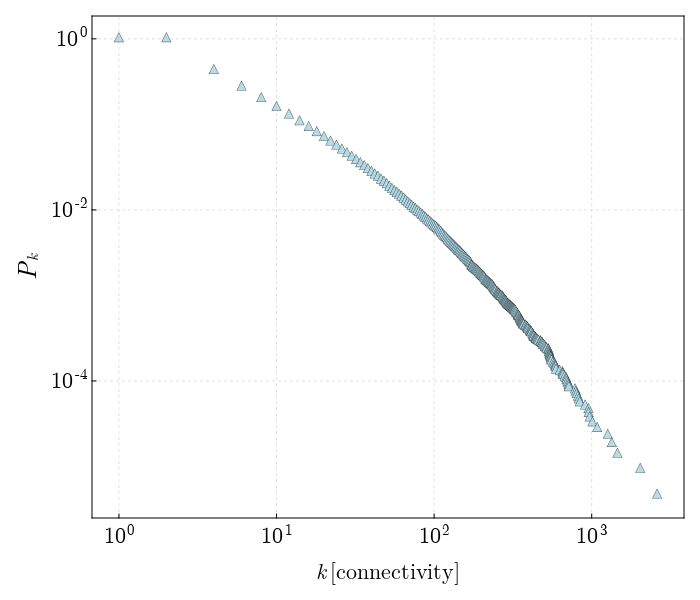

In [194]:
markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", ylabelsize = 26, xscale=log10, yscale=log10,
xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)


# scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
# color=(colors[1], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

scatter!(ax1, x, y,
color=(colors[1], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

fig

In [201]:
lomax_cdf = st.lomax.cdf(x,y, c)

lomax_ccdf = 1 .- lomax_cdf;

In [202]:
lomax_cdf = st.lomax.cdf(x,y, c)

258-element Vector{Float64}:
 0.0
 0.2880320701947821
 0.4056456869261418
 0.36804101626945623
 0.32975502520787436
 0.2962095273822172
 0.26804184068519205
 0.24249133064417008
 0.22153967392198987
 0.2038243634304752
 ⋮
 0.00028539129861473794
 0.0002542228999309099
 0.00022375639025462766
 0.00019375572717840619
 0.00016501694154499763
 0.0001331230741876029
 0.00010097478147874086
 7.039958804514922e-5
 3.633987369203e-5

In [204]:
lomax_ccdf = 1 .- lomax_cdf

258-element Vector{Float64}:
 1.0
 0.711967929805218
 0.5943543130738582
 0.6319589837305437
 0.6702449747921256
 0.7037904726177828
 0.7319581593148079
 0.7575086693558299
 0.7784603260780101
 0.7961756365695248
 ⋮
 0.9997146087013853
 0.9997457771000691
 0.9997762436097454
 0.9998062442728216
 0.999834983058455
 0.9998668769258124
 0.9998990252185213
 0.9999296004119549
 0.999963660126308

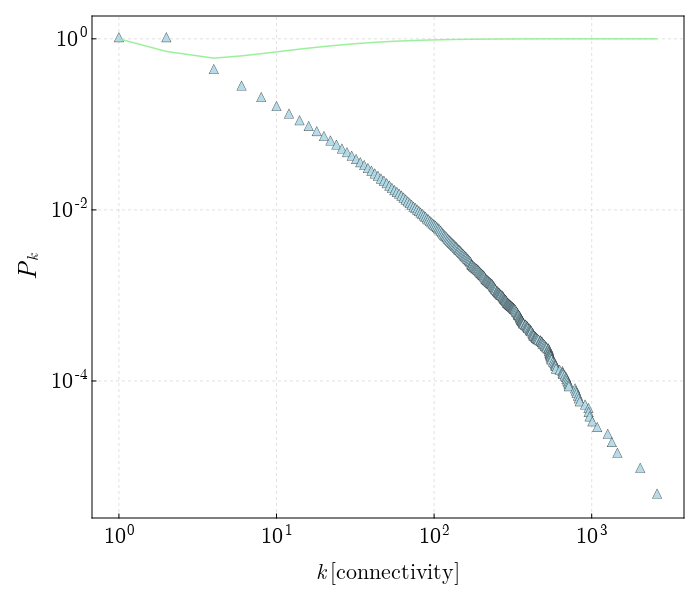

In [205]:
markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", ylabelsize = 26, xscale=log10, yscale=log10,
xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)


# scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
# color=(colors[1], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

scatter!(ax1, x, y,
color=(colors[1], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

lines!(ax1, x, lomax_ccdf,
color=(colors[2], 0.9), strokewidth=0.3, marker=markers[1], markersize=13)

fig